<a href="https://colab.research.google.com/github/RahmanMonty/Data606Capstone/blob/main/Arima_Model_BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt
import seaborn as sns
import random
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import preprocessing

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import pandas as pd
df = pd.read_excel('/content/Part1_Crime_data.xlsx')


In [ ]:
df.head()

,X,Y,RowID,CrimeDateTime,CrimeCode,Location,Description,Inside_Outside,Weapon,Post,District,Neighborhood,Latitude,Longitude,GeoLocation,Premise,VRIName,Total_Incidents,Shape
0,1.431688e+06,604046.096242,1,2021/07/03 14:32:00+00,6E,3300 RICHMOND AVE,LARCENY,NaN,NaN,432,NORTHEAST,BELAIR-EDISON,39.3245,-76.5781,"(39.3245,-76.5781)",NaN,NaN,1,NaN
1,1.415386e+06,598803.710854,2,2021/07/03 05:21:54+00,9S,1100 W NORTH AVE,SHOOTING,Outside,FIREARM,133,CENTRAL,DRUID HEIGHTS,39.3103,-76.6358,"(39.3103,-76.6358)",STREET,NaN,1,NaN
2,1.413955e+06,581387.604790,3,2021/07/03 01:37:14+00,9S,2400 ANNOR CT,SHOOTING,Outside,FIREARM,921,SOUTHERN,WESTPORT,39.2625,-76.6411,"(39.2625,-76.6411)",STREET,NaN,1,NaN
3,1.413955e+06,581387.604790,4,2021/07/03 01:37:14+00,9S,2400 ANNOR CT,SHOOTING,Outside,FIREARM,921,SOUTHERN,WESTPORT,39.2625,-76.6411,"(39.2625,-76.6411)",STREET,NaN,1,NaN
4,1.424268e+06,586493.057063,5,2021/07/03 14:00:00+00,6E,500 HARBORVIEW DR,LARCENY,I,NaN,943,SOUTHERN,INNER HARBOR,39.2764,-76.6046,"(39.2764,-76.6046)",PARKING LOT-INSIDE,NaN,1,NaN


In [ ]:
df["Month"] = pd. DatetimeIndex(df['CrimeDateTime']).month
df["Year"] = pd. DatetimeIndex(df['CrimeDateTime']).year

### Because data was not accurately documented prior to the year 2014 I will select only data points past 2014.

In [ ]:
df = df[df["Year"] > 2014]

In [ ]:
df.head()

,X,Y,RowID,CrimeDateTime,CrimeCode,Location,Description,Inside_Outside,Weapon,Post,District,Neighborhood,Latitude,Longitude,GeoLocation,Premise,VRIName,Total_Incidents,Shape,Month,Year
0,1.431688e+06,604046.096242,1,2021/07/03 14:32:00+00,6E,3300 RICHMOND AVE,LARCENY,NaN,NaN,432,NORTHEAST,BELAIR-EDISON,39.3245,-76.5781,"(39.3245,-76.5781)",NaN,NaN,1,NaN,7,2021
1,1.415386e+06,598803.710854,2,2021/07/03 05:21:54+00,9S,1100 W NORTH AVE,SHOOTING,Outside,FIREARM,133,CENTRAL,DRUID HEIGHTS,39.3103,-76.6358,"(39.3103,-76.6358)",STREET,NaN,1,NaN,7,2021
2,1.413955e+06,581387.604790,3,2021/07/03 01:37:14+00,9S,2400 ANNOR CT,SHOOTING,Outside,FIREARM,921,SOUTHERN,WESTPORT,39.2625,-76.6411,"(39.2625,-76.6411)",STREET,NaN,1,NaN,7,2021
3,1.413955e+06,581387.604790,4,2021/07/03 01:37:14+00,9S,2400 ANNOR CT,SHOOTING,Outside,FIREARM,921,SOUTHERN,WESTPORT,39.2625,-76.6411,"(39.2625,-76.6411)",STREET,NaN,1,NaN,7,2021
4,1.424268e+06,586493.057063,5,2021/07/03 14:00:00+00,6E,500 HARBORVIEW DR,LARCENY,I,NaN,943,SOUTHERN,INNER HARBOR,39.2764,-76.6046,"(39.2764,-76.6046)",PARKING LOT-INSIDE,NaN,1,NaN,7,2021


### Converting the dataframe CrimeDateTime column into pandas datetime so that it is in an appropriate datatype to use with our ARIMA model.

In [ ]:
df['CrimeDateTime'] = pd.to_datetime(df['CrimeDateTime'], errors='coerce')

In [ ]:
Month_Count = df['Month'].groupby(df.CrimeDateTime.dt.date).count()
Month_Count = Month_Count.reset_index()

In [ ]:
Month_Count.dtypes

CrimeDateTime    object
Month             int64
dtype: object

In [ ]:
Month_Count.CrimeDateTime	 = pd.to_datetime(Month_Count.CrimeDateTime	)

In [ ]:
df = df[df["Year"] > 2014]

In [ ]:
Month_Count.head()

,CrimeDateTime,Month
0,2015-01-01,162
1,2015-01-02,108
2,2015-01-03,74
3,2015-01-04,96
4,2015-01-05,122


### Plotting our new dataframe (Month_Count) that has CrimeDateTime and count of crimes per month as the two columns / features for our model

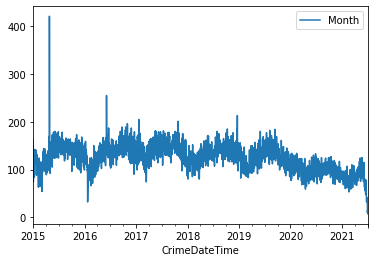

In [ ]:
Month_Count.plot(x='CrimeDateTime')

#### Indexing our CrimeDateTime column so that our ARIMA model has a starting point as the set location.

In [ ]:
Month_Count = Month_Count.set_index('CrimeDateTime')

In [ ]:
Month_Count.head()

,Month
CrimeDateTime,
2015-01-01,162
2015-01-02,108
2015-01-03,74
2015-01-04,96
2015-01-05,122


### Now that we have isolated the number of crimes in a given month we can begin conducting our ARIMA Model on the dataset feature.

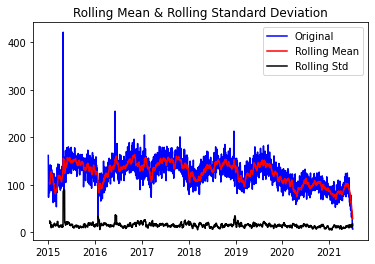

In [ ]:
rolling_mean = Month_Count.rolling(window = 12).mean()
rolling_std = Month_Count.rolling(window = 12).std()
plt.plot(Month_Count, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

#### Here we are plotting the Original dataset, the Rolling Mean, and the Roling Standard deviation to get an idea of our crime features. Because the Rolling Mean is not following a consistent pattern, we can conclude that the time series data is not stationary. This means that it is an appropriate data set for the ARIMA model.

In [ ]:
result = adfuller(Month_Count['Month'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.212325573243999
p-value: 0.668271214639482
Critical Values:
	1%: -3.4331298055777806
	5%: -2.862768070104647
	10%: -2.567423754896525


#### Our p-Value is greater than the outset of .05. Things are looking good. ^^^


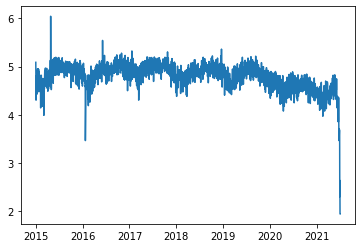

In [ ]:
df_log = np.log(Month_Count)
plt.plot(df_log)

### Here we are checking to see if the two sets we are running are stationary. We are defining our function get_stationarity

In [ ]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Month'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))


#### For the first test, we are subtracting the rolling mean from df_log (our original crime data graph). The Rolling Mean and Rolling STD are fairly horizontal.

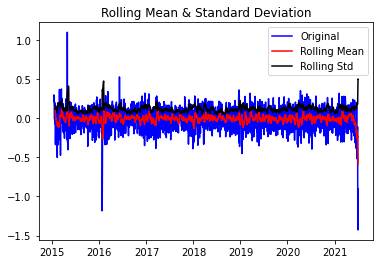

ADF Statistic: -4.553579508523531
p-value: 0.0001571570436487214
Critical Values:
	1%: -3.4331440583819224
	5%: -2.8627743637979775
	10%: -2.5674271058003892


In [ ]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

#### Another test we may do is suptracting the rolling_mean_exp_decay from df_log. The Rolling mean appears to be less horizontal here then it does compared to our first test.

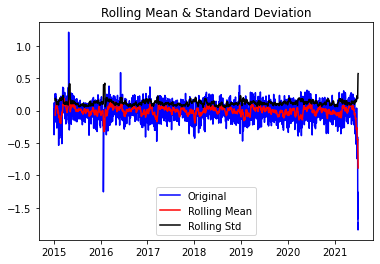

ADF Statistic: -1.4507987807012124
p-value: 0.5576950905804509
Critical Values:
	1%: -3.433132170938598
	5%: -2.8627691145928087
	10%: -2.567424311005166


In [ ]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

### Lastly we will test subtracting time shifting against our original data graph. This resulted in a more horizontal Rolling Mean but a less horizontal Rolling STD.

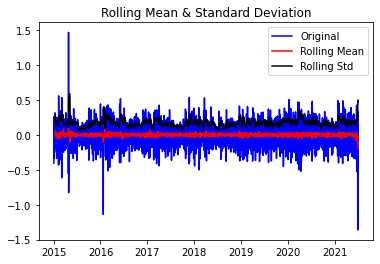

ADF Statistic: -7.512651455596753
p-value: 3.977909597046373e-11
Critical Values:
	1%: -3.43313335512918
	5%: -2.8627696375034364
	10%: -2.567424589414422


In [ ]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

#### Here we are defining the fit of are ARIMA model with an AutoRegressive value of 2, differential of 1, Moving Average value of 2. Autoregressive value says that the past values have an effect on the current values. The moving average indicates that the value of a present day is dependent on the errors that occured on days prior.  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


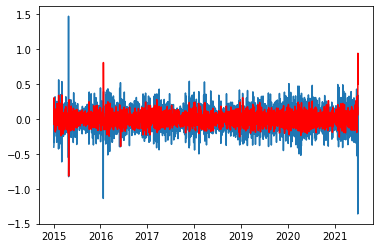

In [ ]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

#### Here is a comparison of our model vs the original data (df_log).

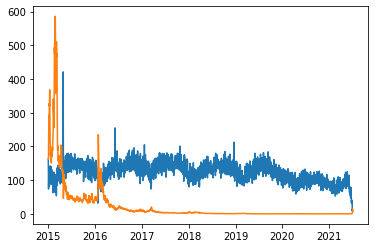

In [ ]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['Month'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(Month_Count)
plt.plot(predictions_ARIMA)

### To counter the change in crime occurances per month, I have choosen the days between 6 and 7 years (2250 and 2300 days from 2014) from the starting point of the data set which we defined earlier to be all data points past 2014. 

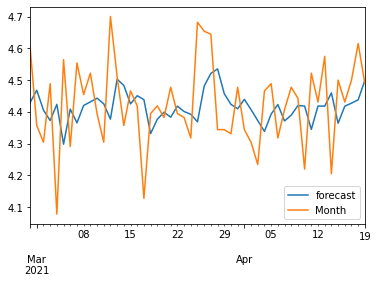

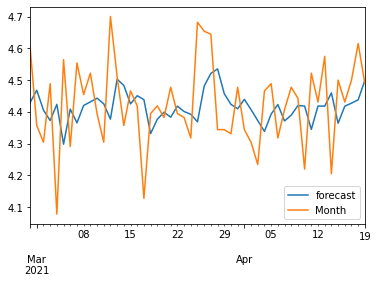

In [52]:
results.plot_predict(2250,2300)

### Because our data set column CrimeDateTime is not a complete set for the year the data appears to indicate a drop in crime counts per month. This is not because crimes in the area are lessening but rather because when the data from the API was pulled, the year was still in progress. The ARIMA model will predict that crimes are in a downward direction but this is nto the case.

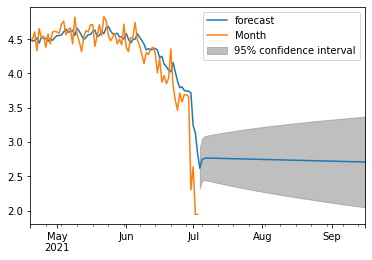

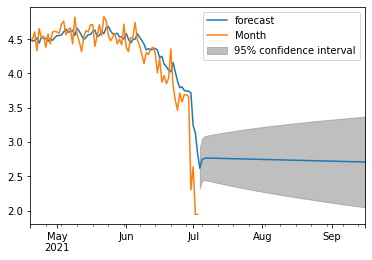

In [53]:
results.plot_predict(2300,2450)

#### Something I can do in the future to test the datas accuracy would be to not test the model against future results, but rather compare it against crimes that have already occured and see how accurate it is at predicting those values. 
#### https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7